The dataset is downloaded from UCI Learning Repository:https://archive.ics.uci.edu/ml/datasets/Activity+recognition+with+healthy+older+people+using+a+batteryless+wearable+sensor, 

Data Set Information:

This dataset contains the motion data of 14 healthy older aged between 66 and 86 years old, performed broadly scripted activities using a batteryless, wearable sensor on top of their clothing at sternum level. Data is sparse and noisy due to the use of a passive sensor.
Participants were allocated in two clinical room settings (S1 and S2). The setting of S1 (Room1) uses 4 RFID reader antennas around the room (one on ceiling level, and 3 on wall level) for the collection of data, whereas the room setting S2 (Room2) uses 3 RFID reader antennas (two at ceiling level and one at wall level) for the collection of motion data.
The activities performed were:
walking to the chair,
sitting on the chair,
getting off the chair,
walking to bed,
lying on bed,
getting off the bed and
walking to the door.
Hence the possible class labels assigned for every sensor observation are:
- Sitting on bed
- Sitting on chair
- Lying on bed
- Ambulating, where ambulating includes standing, walking around the room.

**Note on the dataset:**

Characteristics of Dataset

The files for the dataset represent a individual trial performed by a subject wearing 
a wireless batteryless sensor. Each trial consists of the performance of scripted ADL. 
The files are anonymized; however, indication of the gender of the participant is 
indicated at the end of the file name.

The content of the file is as follows:
Comma separated values (CSV) format.

Column 1: Time in seconds starting from 0 rounded to the closest 0.025s

Column 2: Acceleration reading in G for frontal axis

Column 3: Acceleration reading in G for vertical axis

Column 4: Acceleration reading in G for lateral axis

Column 5: Id of antenna reading sensor

Column 6: Received signal strength indicator (RSSI) 

Column 7: Phase

Column 8: Frequency

Column 9: Label of activity, 1: sit on bed, 2: sit on chair, 3: lying, 4: ambulating

Additional Information

If you wish to use these datasets please cite this paper.

#Loading the dataset

In [1]:
# Using Google colab
##accessing google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMModel,LGBMClassifier
from xgboost import XGBClassifier

I loaded all the study files provided by UCI into my Google directory "/content/drive/MyDrive/Colab Notebooks/DataScience_Project2/Data/". Now I am going to iterate through the files and load them all in one DataFrame. Notice from the UIC Learning Repository description that the files ending with "M" are for male users and the files ending with "F" are for Female users of the study.

In [3]:
# I wanted to add the .csv extension to the loaded files and found:
#https://stackoverflow.com/questions/45627352/python-renaming-all-files-in-a-directory-using-a-loop
'''
path = '/content/drive/MyDrive/Colab Notebooks/DataScience_Project2/Data/'
i = 0
for filename in os.listdir(path):
    os.rename(os.path.join(path,filename), os.path.join(path,filename+'.csv'))
    i = i +1
'''

"\npath = '/content/drive/MyDrive/Colab Notebooks/DataScience_Project2/Data/'\ni = 0\nfor filename in os.listdir(path):\n    os.rename(os.path.join(path,filename), os.path.join(path,filename+'.csv'))\n    i = i +1\n"

I need to load the Male datasets into one dataframe and the Female datasets into one frame so I found this tip: https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe

I also wanted to look at the activities per person, and as each file is dedicated to a unique person, I decided to include the person filename as the person's identity for initial assessments.

In [4]:
header_list = ['Time', 'acc_front', 'acc_vert', 'acc_lat', 'antenna_id', 'rssi', 'phase', 'frequency', 'activity']
path = r'/content/drive/MyDrive/Colab Notebooks/DataScience_Project2/Data'
all_files = glob.glob(path + "/*.csv")

li_m = []
li_f = []

for filename in all_files:
    if filename.endswith('M.csv'):
      df = pd.read_csv(filename, names=header_list)
      df['person']=filename.split('M.csv')[0][-5:]
      li_m.append(df)
    elif filename.endswith('F.csv'):
      df = pd.read_csv(filename, names=header_list)
      df['person']=filename.split('F.csv')[0][-5:]
      li_f.append(df)

activity_df_m = pd.concat(li_m, axis=0, ignore_index=True)
activity_df_f = pd.concat(li_f, axis=0, ignore_index=True)

I am going to add a gender column and assign M and F depending on the dataset before appending them both into one

In [5]:
activity_df_f['gender'] = 'F'
activity_df_f.head()

,Time,acc_front,acc_vert,acc_lat,antenna_id,rssi,phase,frequency,activity,person,gender
0,0.00,0.51826,0.89339,0.13456,4,-56.5,5.83680,921.75,1,d1p08,F
1,0.25,0.51826,0.89339,0.13456,3,-68.0,4.84120,925.75,1,d1p08,F
2,0.75,0.51826,0.89339,0.13456,4,-55.5,3.64170,924.25,1,d1p08,F
3,1.25,0.51826,0.89339,0.13456,3,-57.5,1.77790,924.75,1,d1p08,F
4,1.75,0.51826,0.89339,0.13456,4,-61.5,0.24083,922.75,1,d1p08,F


In [6]:
activity_df_m['gender'] = 'M'
activity_df_m.head()

,Time,acc_front,acc_vert,acc_lat,antenna_id,rssi,phase,frequency,activity,person,gender
0,0.00,-0.044557,0.93932,0.111750,1,-58.0,0.17794,920.75,4,d1p02,M
1,0.25,-0.044557,0.93932,0.111750,1,-60.0,0.46940,920.25,4,d1p02,M
2,0.75,-0.044557,0.93932,0.111750,3,-68.5,0.15033,923.25,1,d1p02,M
3,1.50,-0.044557,0.93932,0.111750,4,-57.5,5.10820,925.75,1,d1p02,M
4,2.50,0.612070,0.89339,0.009122,4,-57.5,4.39490,920.75,1,d1p02,M


Appending the dataframes into one dataframe finally :)

a nice walkthrough here: https://www.geeksforgeeks.org/python-pandas-dataframe-append/

In [7]:
activity_df = activity_df_f.append(activity_df_m, ignore_index=True)
activity_df

,Time,acc_front,acc_vert,acc_lat,antenna_id,rssi,phase,frequency,activity,person,gender
0,0.00,0.51826,0.89339,0.134560,4,-56.5,5.83680,921.75,1,d1p08,F
1,0.25,0.51826,0.89339,0.134560,3,-68.0,4.84120,925.75,1,d1p08,F
2,0.75,0.51826,0.89339,0.134560,4,-55.5,3.64170,924.25,1,d1p08,F
3,1.25,0.51826,0.89339,0.134560,3,-57.5,1.77790,924.75,1,d1p08,F
4,1.75,0.51826,0.89339,0.134560,4,-61.5,0.24083,922.75,1,d1p08,F
...,...,...,...,...,...,...,...,...,...,...,...
75123,938.25,0.88175,0.75559,0.145960,1,-64.0,4.85810,925.25,2,d2p21,M
75124,950.00,0.83485,0.77856,0.123150,1,-62.5,2.25340,923.75,2,d2p21,M
75125,959.50,0.83485,0.77856,0.123150,1,-60.0,1.40970,920.25,2,d2p21,M
75126,964.50,0.83485,0.77856,0.123150,1,-59.5,1.34380,920.25,2,d2p21,M


I now have one full dataset with 75128 rows (matches the number of rows on the UCI Learning Repository link) and 10 columns after adding the gender column to the original dataset.

#Data cleaning and EDA

In [8]:
activity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75128 entries, 0 to 75127
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Time        75128 non-null  float64
 1   acc_front   75128 non-null  float64
 2   acc_vert    75128 non-null  float64
 3   acc_lat     75128 non-null  float64
 4   antenna_id  75128 non-null  int64  
 5   rssi        75128 non-null  float64
 6   phase       75128 non-null  float64
 7   frequency   75128 non-null  float64
 8   activity    75128 non-null  int64  
 9   person      75128 non-null  object 
 10  gender      75128 non-null  object 
dtypes: float64(7), int64(2), object(2)
memory usage: 6.3+ MB


In [9]:
activity_df.isnull().sum()

Time          0
acc_front     0
acc_vert      0
acc_lat       0
antenna_id    0
rssi          0
phase         0
frequency     0
activity      0
person        0
gender        0
dtype: int64

In [10]:
# I wanted to get an idea of the value counts over all columns to get a quick idea of the content
# I found the following solution for that: https://blog.softhints.com/pandas-value_counts-multiple-columns/
for col in activity_df.columns:
    print('-' * 40 + col + '-' * 40 , end=' - ')
    display(activity_df[col].value_counts().head(10))

----------------------------------------Time---------------------------------------- - 

0.00     87
7.25     39
44.00    35
10.75    34
9.75     34
9.00     34
1.50     33
9.25     33
0.25     33
1.25     32
Name: Time, dtype: int64

----------------------------------------acc_front---------------------------------------- - 

1.11630    1676
1.09280    1673
1.13970    1642
1.12800    1557
1.15140    1439
1.08110    1420
1.10450    1373
0.34238    1274
0.30721    1273
0.28376    1264
Name: acc_front, dtype: int64

----------------------------------------acc_vert---------------------------------------- - 

-0.036746    1875
 0.973770    1834
 0.055119    1681
 0.009187    1615
-0.059712    1594
-0.013780    1565
 0.032153    1554
 0.939320    1514
 0.985260    1479
 0.020670    1445
Name: acc_vert, dtype: int64

----------------------------------------acc_lat---------------------------------------- - 

-0.036490    2792
-0.093505    2569
-0.025087    2562
-0.047893    2525
-0.070699    2484
-0.104910    2412
-0.013684    2371
-0.059296    2335
-0.002281    2290
-0.082102    2249
Name: acc_lat, dtype: int64

----------------------------------------antenna_id---------------------------------------- - 

3    24718
1    22347
4    14200
2    13863
Name: antenna_id, dtype: int64

----------------------------------------rssi---------------------------------------- - 

-56.5    5024
-57.0    4980
-57.5    4113
-56.0    3544
-58.0    3271
-59.5    3023
-58.5    3019
-59.0    2914
-60.0    2603
-60.5    2352
Name: rssi, dtype: int64

----------------------------------------phase---------------------------------------- - 

0.702560    87
5.321400    87
0.033748    87
6.083800    85
0.092039    85
5.496300    85
6.231000    83
6.274000    82
5.605200    82
0.006136    80
Name: phase, dtype: int64

----------------------------------------frequency---------------------------------------- - 

920.25    7878
920.75    7727
921.25    7607
921.75    7158
922.25    6941
922.75    6513
923.25    6188
923.75    5838
924.25    5515
924.75    4968
Name: frequency, dtype: int64

----------------------------------------activity---------------------------------------- - 

3    51520
1    16406
2     4911
4     2291
Name: activity, dtype: int64

----------------------------------------person---------------------------------------- - 

d1p50    4638
d1p53    4563
d1p45    3339
d1p44    3139
d1p51    3044
d2p02    2992
d1p49    2876
d1p47    2818
d1p46    2542
d2p15    2529
Name: person, dtype: int64

----------------------------------------gender---------------------------------------- - 

F    43828
M    31300
Name: gender, dtype: int64

In [11]:
activity_df.describe()

,Time,acc_front,acc_vert,acc_lat,antenna_id,rssi,phase,frequency,activity
count,75128.000000,75128.000000,75128.000000,75128.000000,75128.000000,75128.000000,75128.000000,75128.000000,75128.000000
mean,299.080416,0.714211,0.345199,-0.217477,2.409581,-58.277253,3.157279,922.670536,2.528378
std,257.503002,0.404585,0.419041,0.438219,1.102165,5.174083,2.182257,1.679093,0.864258
min,0.000000,-0.748080,-0.553490,-1.336400,1.000000,-72.000000,0.000000,920.250000,1.000000
25%,121.250000,0.342380,-0.002297,-0.184730,1.000000,-62.000000,1.032400,921.250000,2.000000
50%,250.715000,0.682420,0.215880,-0.070699,3.000000,-58.000000,2.767300,922.750000,3.000000
75%,402.500000,1.104500,0.858940,0.031928,3.000000,-56.000000,5.358575,924.250000,3.000000
max,1739.400000,1.503200,2.030200,1.217800,4.000000,-38.500000,6.281700,925.750000,4.000000


**Cleaning the Zero Time activity**

In [12]:
# 0 Time values concerns me:
zero_time = activity_df['Time']== 0
activity_df.loc[zero_time, :]

,Time,acc_front,acc_vert,acc_lat,antenna_id,rssi,phase,frequency,activity,person,gender
0,0.0,0.51826,0.89339,0.134560,4,-56.5,5.83680,921.75,1,d1p08,F
92,0.0,0.58862,0.88191,0.100350,4,-56.5,5.46100,923.75,1,d1p09,F
281,0.0,0.60034,0.83597,0.123150,4,-56.0,5.79840,925.75,1,d1p10,F
342,0.0,0.88175,0.74411,0.191570,4,-57.5,5.93500,923.25,1,d1p11,F
531,0.0,0.10787,0.90487,-0.082102,1,-44.5,4.62500,922.25,4,d1p15,F
...,...,...,...,...,...,...,...,...,...,...,...
71119,0.0,0.13132,1.01970,0.157360,3,-59.5,4.08500,922.25,4,d2p18,M
71653,0.0,0.35411,0.95081,0.009122,2,-65.0,5.69410,923.75,4,d2p19,M
72223,0.0,0.43619,0.90487,-0.355770,3,-59.0,2.28410,921.25,1,d2p22,M
72960,0.0,0.49481,0.90487,0.123150,3,-60.5,2.40990,925.25,4,d2p20,M


Looping in the 0 time values and getting the mean time for the same person and same activity.

In [13]:
def get_person_activity_mean_time(person, activity):
  return round(activity_df.loc[(activity_df['person']== person) & (activity_df['activity'] == activity), 'Time'].mean(), 2)
get_person_activity_mean_time('d1p08', 1)

40.33

In [14]:
#looping in the rows and for each zero time and call the above method to get the mean time for the same person and same activity
for index, row in activity_df.iterrows():
  if (row['Time'] == 0.0):
    try:
      activity_df.loc[index:index, ('Time')] = get_person_activity_mean_time(row['person'], row['activity'])
    except ValueError:
      pass
activity_df.loc[activity_df['Time']== 0, :]

,Time,acc_front,acc_vert,acc_lat,antenna_id,rssi,phase,frequency,activity,person,gender
2310,0.0,-0.27906,0.89339,0.18017,2,-48.0,1.6705,922.75,4,d1p31,F
71119,0.0,0.13132,1.01970,0.15736,3,-59.5,4.0850,922.25,4,d2p18,M


Now we only have two activities with 0.0 seconds. That tells me there is only 1 occurance for the activity on this person. I am OK with removing those 2 rows from the dataframe as it seems like it detected the wrong activity.

In [15]:
activity_df.drop(activity_df[activity_df['Time']== 0].index, inplace= True)
activity_df.shape

(75126, 11)

#Visualization

looking for obvious trends around the target

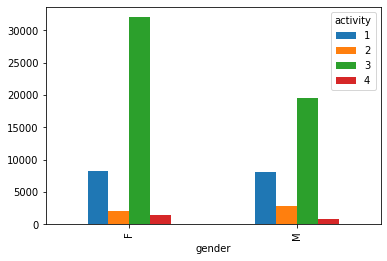

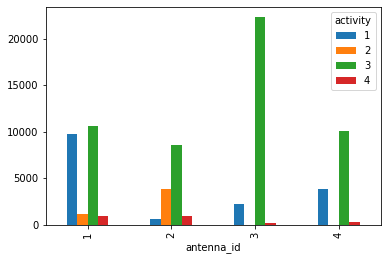

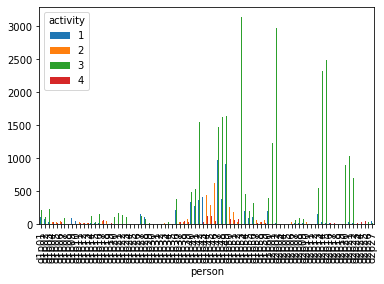

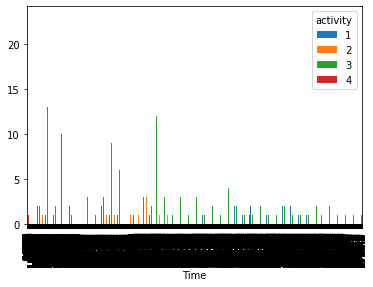

In [16]:
# I decided to create an array of columns/potential-factors and loop through them,
# instead of created a code block from each column/factor
vis_columns = ['gender', 'antenna_id', 'person', 'Time']
for i,v in enumerate(vis_columns):
  activity_df.groupby([v,'activity'])['activity'].count().unstack().plot(kind='bar')

In [17]:
#Gender is a nominal categorical column
#mapping M to 0 and F to 1
activity_df['gender']= activity_df['gender'].map({'M': 0, 'F': 1})
activity_df.head()

,Time,acc_front,acc_vert,acc_lat,antenna_id,rssi,phase,frequency,activity,person,gender
0,40.33,0.51826,0.89339,0.13456,4,-56.5,5.83680,921.75,1,d1p08,1
1,0.25,0.51826,0.89339,0.13456,3,-68.0,4.84120,925.75,1,d1p08,1
2,0.75,0.51826,0.89339,0.13456,4,-55.5,3.64170,924.25,1,d1p08,1
3,1.25,0.51826,0.89339,0.13456,3,-57.5,1.77790,924.75,1,d1p08,1
4,1.75,0.51826,0.89339,0.13456,4,-61.5,0.24083,922.75,1,d1p08,1


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


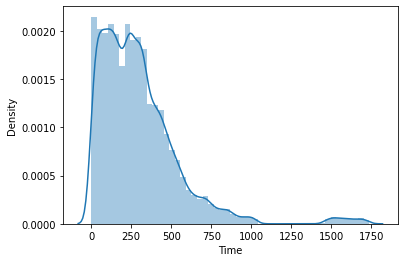

In [18]:
sns.distplot(activity_df['Time']);

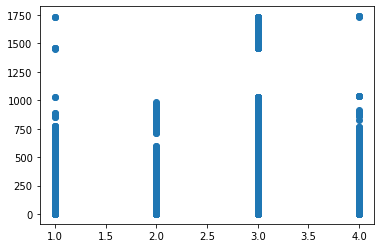

In [19]:
plt.scatter(activity_df['activity'], activity_df['Time']);

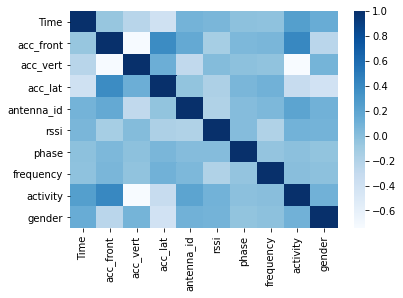

In [20]:
sns.heatmap(activity_df.corr(), cmap='Blues')

#Supervised machine Learning - Multi Class Classification

In [23]:
activity_df.head()

,Time,acc_front,acc_vert,acc_lat,antenna_id,rssi,phase,frequency,activity,person,gender
0,40.33,0.51826,0.89339,0.13456,4,-56.5,5.83680,921.75,1,d1p08,1
1,0.25,0.51826,0.89339,0.13456,3,-68.0,4.84120,925.75,1,d1p08,1
2,0.75,0.51826,0.89339,0.13456,4,-55.5,3.64170,924.25,1,d1p08,1
3,1.25,0.51826,0.89339,0.13456,3,-57.5,1.77790,924.75,1,d1p08,1
4,1.75,0.51826,0.89339,0.13456,4,-61.5,0.24083,922.75,1,d1p08,1


In [24]:
#Save the data to X and target to y
X = activity_df.drop(columns=['activity', 'person'])
y = activity_df['activity']
print(f'X shape: {X.shape}, y shape: {y.shape}')

X shape: (75126, 9), y shape: (75126,)


In [26]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

**Logistic Regression**

In [31]:
logreg = LogisticRegression(max_iter=70000)
logreg.fit(X_train, y_train)
print('Training accuracy:', logreg.score(X_train, y_train))
print('Testing accuracy:', logreg.score(X_test, y_test))

Training accuracy: 0.9259725969047281
Testing accuracy: 0.9252475774677883


**Decision Tree**

In [28]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print('Training accuracy:', dt.score(X_train, y_train))
print('Testing accuracy:', dt.score(X_test, y_test))

Training accuracy: 1.0
Testing accuracy: 0.985943988925567


**Random Forest**

In [29]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print('Training accuracy:', rf.score(X_train, y_train))
print('Testing accuracy:', rf.score(X_test, y_test))

Training accuracy: 1.0
Testing accuracy: 0.9905228410179959


**Boosting**

In [33]:
# Gradient Boosting
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
print('Training accuracy:', gbc.score(X_train, y_train))
print('Testing accuracy:', gbc.score(X_test, y_test))

Training accuracy: 0.9818259264517961
Testing accuracy: 0.9805664998402726


In [34]:
#LightGBM
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
print('Training accuracy:', lgbm.score(X_train, y_train))
print('Testing accuracy:', lgbm.score(X_test, y_test))

Training accuracy: 0.9964148800227176
Testing accuracy: 0.9899371738898946


In [35]:
#XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
print('Training accuracy:', xgb.score(X_train, y_train))
print('Testing accuracy:', xgb.score(X_test, y_test))

Training accuracy: 0.9774953854891382
Testing accuracy: 0.9775849217335747


So far, it looks like Random Forest was the best model for this dataset.